<a href="https://colab.research.google.com/github/prakriti-yeole/portfolio/blob/main/interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving BRDhavdeL.txt to BRDhavdeL.txt


In [2]:
import matplotlib.pyplot as plt
import numpy as np
# Read data from the uploaded file
file_name = "BRDhavdeL.txt"  # Replace with your file name
with open(file_name, "r") as file:
    lines = file.readlines()


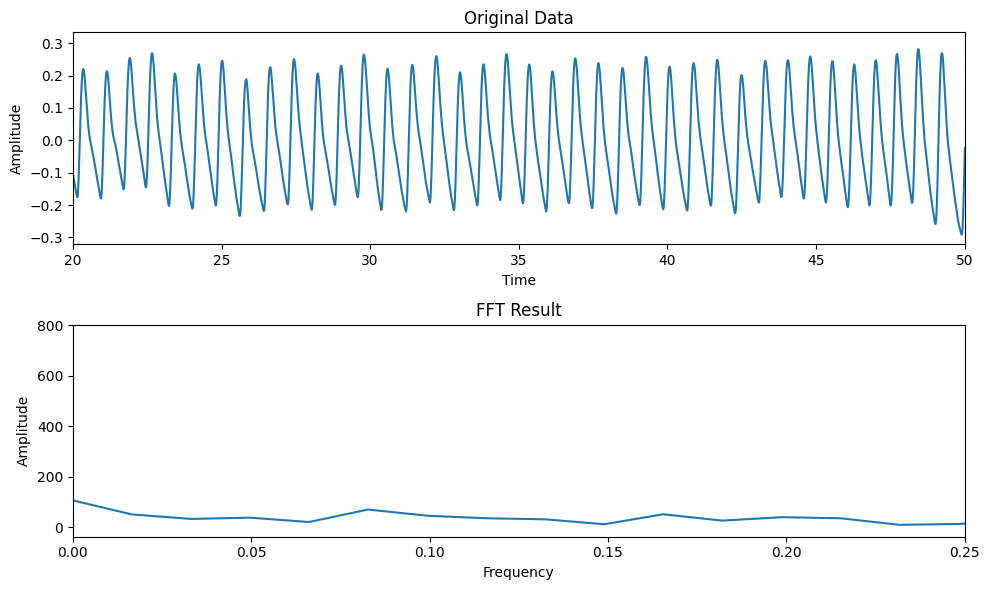

In [3]:
# Process data and extract x, y values
x_values = []
y_values = []
for line in lines:
    x, y = map(float, line.strip().split())  # Assuming the data is in space-separated format
    x_values.append(x)
    y_values.append(y)

    y_fft = np.fft.fft(y_values)
    n = len(y_values)
fs = 200
frequencies = np.fft.fftfreq(n, d=1/fs)

plt.figure(figsize=(10, 6))

# Plot original data
plt.subplot(2, 1, 1)
plt.plot(x_values, y_values)
plt.xlim(20, 50)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Original Data")


# Plot FFT result
plt.subplot(2, 1, 2)
plt.plot(frequencies[:n//2], np.abs(y_fft[:n//2]))
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("FFT Result")
plt.xlim(0.00, 0.25)
plt.tight_layout()
plt.show()

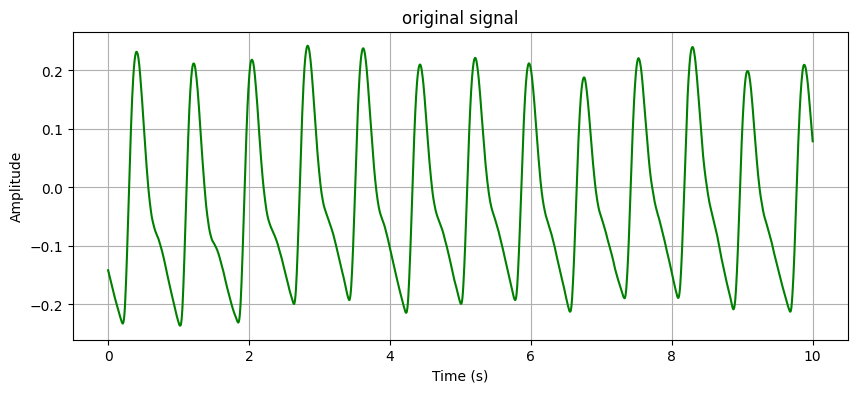

In [7]:
sampling_rate = 1000  # Hz
t = np.arange(0, 10, 1 / sampling_rate)
original_signal = np.interp(t, x_values, y_values)

plt.figure(figsize=(10, 4))

plt.plot(t, original_signal, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('original signal')
plt.grid(True)
plt.show()

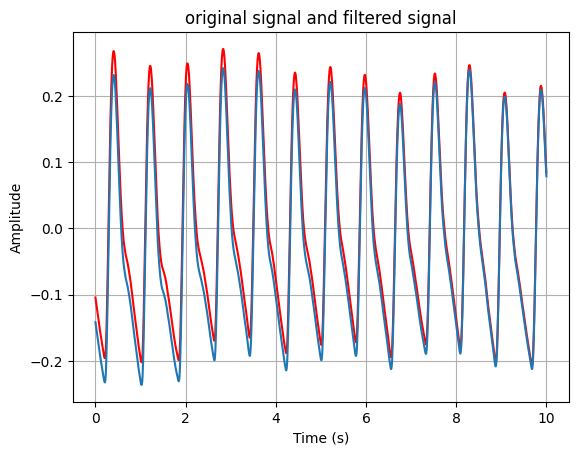

In [17]:
# interpolation method
from math import sqrt

# Daubechies 4 Constant
c0 = (1+sqrt(3))/(4*sqrt(2))
c1 = (3+sqrt(3))/(4*sqrt(2))
c2 = (3-sqrt(3))/(4*sqrt(2))
c3 = (1-sqrt(3))/(4*sqrt(2))

def conv(x, h):
    """ Perform the convolution operation between two input signals. The output signal length
    is the sum of the lenght of both input signal minus 1."""
    length = len(x) + len(h) - 1
    y = [0]*length

    for i in range(len(y)):
        for j in range(len(h)):
            if i-j >= 0 and i-j < len(x):
                y[i] += h[j] * x[i-j]

    return y

def db4_dec(x, level):
    """ Perform the wavelet decomposition to signal x with Daubechies order 4 basis function as many as specified level"""

    # Decomposition coefficient for low pass and high pass
    lpk = [c0, c1, c2, c3]
    hpk = [c3, -c2, c1, -c0]

    result = [[]]*(level+1)
    x_temp = x[:]
    for i in range(level):
        lp = conv(x_temp, lpk)
        hp = conv(x_temp, hpk)

        # Downsample both output by half
        lp_ds=[0]*(len(lp)// 2)
        hp_ds=[0]*(len(hp)// 2)
        for j in range(len(lp_ds)):
            lp_ds[j] = lp[2*j+1]
            hp_ds[j] = hp[2*j+1]

        result[level-i] = hp_ds
        x_temp = lp_ds[:]

    result[0] = lp_ds
    return result

def db4_rec(signals, level):
    """ Perform reconstruction from a set of decomposed low pass and high pass signals as deep as specified level"""

    # Reconstruction coefficient
    lpk = [c3, c2, c1, c0]
    hpk = [-c0, c1, -c2, c3]

    cp_sig = signals[:]
    for i in range(level):
        lp = cp_sig[0]
        hp = cp_sig[1]

        # Verify new length
        length = 0
        if len(lp) > len(hp):
            length = 2*len(hp)
        else:
            length = 2*len(lp)

        # Upsampling by 2
        lpu = [0]*(length+1)
        hpu = [0]*(length+1)
        index = 0
        for j in range(length+1):
            if j%2 != 0:
                lpu[j] = lp[index]
                hpu[j] = hp[index]
                index += 1

        # Convolve with reconstruction coefficient
        lpc = conv(lpu, lpk)
        hpc = conv(hpu, hpk)

        # Truncate the convolved output by the length of filter kernel minus 1 at both end of the signal
        lpt = lpc[3:-3]
        hpt = hpc[3:-3]

        # Add both signals
        org = [0]*len(lpt)
        for j in range(len(org)):
            org[j] = lpt[j] + hpt[j]

        if len(cp_sig) > 2:
            cp_sig = [org]+cp_sig[2:]
        else:
            cp_sig = [org]

    return cp_sig[0]

def calcEnergy(x):
    """ Calculate the energy of a signal which is the sum of square of each points in the signal."""
    total = 0
    for i in x:
        total += i*i
    return total

def bwr(raw):
    """ Perform the baseline wander removal process against signal raw. The output of this method is signal with correct baseline
    and its baseline """
    en0 = 0
    en1 = 0
    en2 = 0
    n = 0

    curlp = raw[:]
    num_dec = 0
    last_lp = []
    while True:


        # Decompose 1 level
        [lp, hp] = db4_dec(curlp,1)

        # Shift and calculate the energy of detail/high pass coefficient
        en0 = en1
        en1 = en2
        en2 = calcEnergy(hp)


        # Check if we are in the local minimum of energy function of high-pass signal
        if en0 > en1 and en1 < en2:
            last_lp = curlp
            break

        curlp = lp[:]
        num_dec = num_dec+1

    # Reconstruct the baseline from this level low pass signal up to the original length
    base = last_lp[:]
    for i in range(num_dec):
        base = db4_rec([base,[0]*len(base)], 1)

    # Correct the original signal by subtract it with its baseline
    ecg_out = [0]*len(raw)
    for i in range(len(raw)):
        ecg_out[i] =  raw[i] - base[i]

    return ecg_out


filtered_signal = bwr(original_signal)

plt.plot(t, filtered_signal, color='red')
plt.plot(t, original_signal, label='corrupted PPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('original signal and filtered signal')
plt.grid(True)


plt.show()